## Analysis

Imports

In [1]:
import os
import matplotlib.pyplot as plt
import time, os, json
import pandas as pd
from scipy import stats 
from tqdm import tqdm
import seaborn as sns
import jax

from jax import random
from jax.config import config 
import jax.numpy as np
from jax import vmap
import pdb
import optax
from functools import partial

import math
import csv
import time
#from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
import numpy
from util import create_gratings
from SSN_classes_jax_jit import SSN2DTopoV1_AMPAGABA_ONOFF

Functions

In [2]:
def assemble_pars(all_pars, matrix = True):
    '''
    Take parameters from csv file and 
    
    '''
    pre_train = np.asarray(all_pars.iloc[0].tolist())
    post_train =  np.asarray(all_pars.iloc[-1].tolist())

    if matrix == True:
        matrix_pars = lambda Jee, Jei, Jie, Jii: np.array([[Jee, Jei], [Jie,  Jii]])

        pre_train = matrix_pars(*pre_train)
        post_train = matrix_pars(*post_train)
    
    
    return pre_train, post_train


def plot_acc_vs_param(to_plot, lambdas, type_param = None, param = None):
    '''
    Input:
        Matrix with shape (N+1, length of lambda) - each row corresponds to a different value of lambda, params at that value and 
        the accuracy obtained
    Output:
        Plot of the desired param against the accuracy 
    '''
    
    plt.scatter(np.abs(to_plot[:, param]).T, to_plot[:, 0].T, c = lambdas)
    plt.colorbar()
    
    plt.ylabel('Accuracy')
    
    if type_param == 'J':
        if param ==1:
            plt.xlabel('J_EE')
        if param ==2:
            plt.xlabel('J_EI')
        if param ==3:
            plt.xlabel('J_IE')
        if param ==4:
            plt.xlabel('J_II')
            
    if type_param == 's':
        if param ==1:
            plt.xlabel('s_EE')
        if param ==2:
            plt.xlabel('s_EI')
        if param ==3:
            plt.xlabel('s_IE')
        if param ==4:
            plt.xlabel('s_II')
    
    if type_param == 'c':
        if param ==1:
            plt.xlabel('c_E')
        if param ==2:
            plt.xlabel('c_I')

    plt.show()


    
def case_1(pre_param, post_param, test_data):
    '''
    Interpolate all parameters and evaluate accuracy at each value.
    Input:
        list of pre and post values of J
        opt_pars for other optimisation parameters
        test_data
    Output:
        Matrix with shape (N+1, length of lambda) - each row corresponds to a different value of lambda, params at that value and 
        the accuracy obtained   
    '''
    
    values = []
    accuracy = []
    lambdas = np.linspace(0,1,10)
    for lamb in lambdas:
        true_acc= 0
        new_param = {}

        for key in opt_pars.keys():
            new_param[key] =(1-lamb)*pre_param[key] + lamb*post_param[key]
        
        print(new_param)
        new_param['logJ_2x2'] = np.log(new_param['logJ_2x2']*signs)
        new_param['logs_2x2'] = np.log(new_param['logs_2x2'])
        
        
        val_loss, true_acc, _= vmap_eval(new_param, ssn_pars, grid_pars, conn_pars, test_data, filter_pars,  conv_pars, loss_pars, bernoulli=True, sig_noise=2.5)
        print('lambda ', lamb, ', accuracy', true_acc)
        #values.append([new_param[key].ravel() for key in new_param.keys()])
        accuracy.append(true_acc)

    return accuracy, lambdas #np.column_stack([np.vstack(accuracy), np.vstack(values)])
    

def case_2(pre_param, post_param, opt_pars, test_data, type_param = None, index=None):
    '''
    Interpolate a single trained parameter and evaluate accuracy at each value. Produce plot of param against accuracy
    Input:
        list of pre and post values of J
        opt_pars for other optimisation parameters
        test_data
        desired param from the matrix (0,0) - J_EE ¦ (0,1) - J_EI, ¦ (1,0) - J_IE ¦ (1,1) - J_II
    Output:
        Matrix with shape (N+1, length of lambda) - each row corresponds to a different value of lambda, params at that value and 
        the accuracy obtained
        Plot of the changing parameter against accuracy
        
    '''
    values = []
    accuracy = []
    lambdas = np.linspace(0,1,10)
    parameter_matrix = np.asarray([[1,2],[3,4]]) 
    plot_param = parameter_matrix[index]
    
    #Create evenly spaced parameters to interpolate
    lambdas = np.linspace(0,1,10)
    
    for lamb in lambdas:
        
        #Update values of J according to interpolation
        new_param = np.copy(post_param)
        new_param = new_param.at[index].set((1-lamb)*pre_param[index] + lamb*post_param[index])
        
        #Take logs before passing through model
        if type_param =='J':
            opt_pars['logJ_2x2'] = np.log(new_param*signs)
        if type_param =='s':
            opt_pars['logs_2x2'] =  np.log(new_param)
        if type_param =='c':
            opt_pars['c_E'] = new_param[0]
            opt_pars['c_I'] = new_param[1]
            plot_param = int(index+1)

        
        #Evaluate accuracy
        val_loss, true_acc, ber_acc= vmap_eval(opt_pars, ssn_pars, grid_pars, conn_pars, test_data, filter_pars,  conv_pars, loss_pars, bernoulli=True, sig_noise=2.5)
        print('lambda ', lamb, ', accuracy', true_acc)
        
        #Store values of J and accuracy
        values.append([param for param in new_param.ravel()])
        accuracy.append(true_acc)

    to_plot = np.column_stack([np.vstack(accuracy), np.vstack(values)])
    
    #Plot parameters
    plot_acc_vs_param(to_plot, lambdas, type_param = type_param, param= plot_param)
    
    return to_plot



Parameters

In [3]:
results_file = '/mnt/d/ABG_Projects_Backup/ssn_modelling/ssn-simulator/results/jitted_function/fixed_w_ssn_train70.csv'
results = pd.read_csv(results_file, header = 0)
all_J = results[['J_EE', 'J_EI', 'J_IE', 'J_II' ]]
all_s = results[['s_EE', 's_EI', 's_IE', 's_II' ]]
all_c = results[['c_E', 'c_I']]

pre_c, post_c = assemble_pars(all_c, matrix=False)
pre_s, post_s = assemble_pars(all_s)
pre_J, post_J = assemble_pars(all_J)

signs=np.array([[1, -1], [1, -1]])

opt_pars= {}
#Initialise opt_pars as post training values
opt_pars['logs_2x2'] = np.log(post_s)
opt_pars['c_E'] = post_c[0]
opt_pars['c_I'] = post_c[1]
opt_pars['logJ_2x2'] = np.log(post_J*signs)
opt_pars['w_sig'] = np.asarray([ 0.12605566,  0.1273912,   0.18054508, -0.27392012, -0.01211993, -0.03041697,
  0.0826202,   0.41804752,  0.1202573,  -0.03632501,  0.18295377,  0.30918923,
 -0.1940052,   0.20544377, -0.2499748,  -0.08071887,  0.19058336,  0.03633068,
 -0.02569352, -0.16947141, -0.2595211,  -0.04320447,  0.13482924, -0.05088398,
  0.1140677 ])
opt_pars['b_sig'] = np.asarray(-0.06537655)

pre_opt_pars = dict()
pre_opt_pars['logs_2x2'] = pre_s#np.log(pre_s)
pre_opt_pars['c_E'] = pre_c[0]
pre_opt_pars['c_I'] = pre_c[1]
pre_opt_pars['logJ_2x2'] = pre_J# np.log(pre_J*signs)
pre_opt_pars['w_sig'] =  np.asarray([ 0.12605566,  0.1273912,   0.18054508, -0.27392012, -0.01211993, -0.03041697,
  0.0826202,   0.41804752,  0.1202573,  -0.03632501,  0.18295377,  0.30918923,
 -0.1940052,   0.20544377, -0.2499748,  -0.08071887,  0.19058336,  0.03633068,
 -0.02569352, -0.16947141, -0.2595211,  -0.04320447,  0.13482924, -0.05088398,
  0.1140677 ])
pre_opt_pars['b_sig'] = np.asarray(-0.06537655)

Set 2 parameters

In [89]:
Js0_set2 = [1.72881688, 1.29887564, 1.48514091, 0.76417991]
gE, gI = 0.5821754, 0.22660373

sigEE, sigIE = 0.225, 0.242
sigEI, sigII = .09, .09
class conn_pars_set2():
    PERIODIC = False
    p_local = [0, 0] # [p_local_EE, p_local_IE],
    sigma_oris = 1000
make_J2x2 = lambda Jee, Jei, Jie, Jii: np.array([[Jee, -Jei], [Jie,  -Jii]]) * np.pi * ssn_pars.psi
J_2x2_set2 = make_J2x2(*Js0_set2)
s_2x2_set2 = np.array([[sigEE, sigEI],[sigIE, sigII]])

In [7]:
######################### STIMULI PARAMETERS ########################
sigma_g= 0.5
k = np.pi/(6*sigma_g)

#Stimuli parameters
ref_ori = 55

#Assemble parameters in dictionary
general_pars = dict(k=k , edge_deg=3.2,  degree_per_pixel=0.05)
stimuli_pars = dict(outer_radius=3, inner_radius=2.5, grating_contrast=0.8, std = 0, jitter_val = 5)
stimuli_pars.update(general_pars)



######################### NETWORK PARAMETERS ########################
class ssn_pars():
    n = 2
    k = 0.04
    tauE = 30 # in ms
    tauI = 10 # in ms~
    psi = 0.774
    A=None
    tau_s = np.array([5, 7, 100]) #in ms, AMPA, GABA, NMDA current decay time constants
    

#Grid parameters
class grid_pars():
    gridsize_Nx = 9 # grid-points across each edge # gives rise to dx = 0.8 mm
    gridsize_deg = 2 * 1.6 # edge length in degrees
    magnif_factor = 2  # mm/deg
    hyper_col = 0.8 # mm   
    sigma_RF = 0.4 # deg (visual angle)
    
    
class conn_pars():
    PERIODIC = False
    p_local = [0.4, 0.7]
    sigma_oris = 1000
    
class filter_pars():
    sigma_g = numpy.array(0.5)
    conv_factor = numpy.array(2)
    k = numpy.array(1.0471975511965976)
    edge_deg = numpy.array( 3.2)
    degree_per_pixel = numpy.array(0.05)
    


#########################OPTIMIZATION PARAMETERS ########################


make_J2x2 = lambda Jee, Jei, Jie, Jii: np.array([[Jee, -Jei], [Jie,  -Jii]]) * np.pi * ssn_pars.psi
J_2x2 = make_J2x2(*post_J.ravel())

class conv_pars:
    dt = 1
    xtol = 1e-05
    Tmax = 1000
    verbose = False
    silent = True

class loss_pars:
    lambda_1 = 1
    lambda_2 = 1
    lambda_w = 1
    lambda_b = 1
    

initial_ssn=SSN2DTopoV1_AMPAGABA_ONOFF(ssn_pars=ssn_pars, grid_pars=grid_pars, conn_pars=conn_pars, filter_pars=filter_pars, J_2x2=J_2x2, s_2x2=post_s, gE=1, gI=1)
ssn_pars.A=initial_ssn.A

In [8]:
ssn_pars.A

DeviceArray(0.00082991, dtype=float32)

In [9]:
def plot_losses(training_losses, validation_losses, epochs_to_save):
    plt.plot(training_losses.T, label = ['Binary cross entropy', 'Avg_dx', 'R_max', 'w', 'b', 'Training total'] )
    plt.plot(epochs_to_save, validation_losses, label='Validation')
    plt.legend()
    plt.title('Training losses')
    plt.show()
    
    
def create_data(stimuli_pars, number=100, offset = 5, ref_ori=55):
    
    '''
    Create data for given jitter and noise value for testing (not dataloader)
    '''
    data = create_gratings(ref_ori=ref_ori, number=number, offset=offset, **stimuli_pars)
    train_data = next(iter(DataLoader(data, batch_size=len(data), shuffle=False)))
    train_data['ref'] = train_data['ref'].numpy()
    train_data['target'] = train_data['target'].numpy()
    train_data['label'] = train_data['label'].numpy()
    
    return train_data



def constant_to_vec(c_E, c_I):
    
    matrix_E = np.zeros((9,9))
    matrix_E = matrix_E.at[2:7, 2:7].set(c_E)
    vec_E = np.ravel(matrix_E)
    
    matrix_I = np.zeros((9,9))
    matrix_I = matrix_I.at[2:7, 2:7].set(c_I)
    vec_I = np.ravel(matrix_I)
    
    constant_vec = np.hstack((vec_E, vec_E, vec_I, vec_I))
    return constant_vec

def sigmoid(x, epsilon = 0.001):
    
    '''
    Introduction of epsilon stops asymptote from reaching 1 (avoids NaN)
    '''
   
    sig = 1/(1+np.exp(x))
    
    return (1 - 2*epsilon)*sig + epsilon


def binary_loss(n, x):
    return - (n*np.log(x) + (1-n)*np.log(1-x))

def exponentiate(opt_pars):
    signs=np.array([[1, -1], [1, -1]]) 
    
    J_2x2 =np.exp(opt_pars['logJ_2x2'])*signs
    s_2x2 = np.exp(opt_pars['logs_2x2'])
    
    return J_2x2, s_2x2

def our_max(x, beta=1):
    max_val = np.log(np.sum(np.exp(x*beta)))/beta
    return max_val

@partial(jax.jit, static_argnums=(1, 2, 3, 5, 6 , 7 , 8 ))#, device = jax.devices()[1]) + ADD 9 FOR TRAINING
def model(opt_pars, ssn_pars, grid_pars, conn_pars, train_data, filter_pars,  conv_pars, loss_pars, bernoulli, sig_noise):
    
    J_2x2, s_2x2 = exponentiate(opt_pars)
    
    #Initialise network
    ssn=SSN2DTopoV1_AMPAGABA_ONOFF(ssn_pars=ssn_pars, grid_pars=grid_pars, conn_pars=conn_pars, filter_pars=filter_pars, J_2x2=J_2x2, s_2x2=s_2x2)
    
    #Create vector using extrasynaptic constants
    constant_vector = constant_to_vec(opt_pars['c_E'], opt_pars['c_I'])
    
    #Apply Gabor filters to stimuli
    output_ref=np.matmul(ssn.gabor_filters, train_data['ref']) + constant_vector
    output_target=np.matmul(ssn.gabor_filters, train_data['target']) + constant_vector
    
    #Rectify output
    SSN_input_ref=np.maximum(0, output_ref)
    SSN_input_target=np.maximum(0, output_target)

    #Find the fixed point 
    x_ref, r_max_ref, avg_dx_ref = obtain_fixed_point(ssn, SSN_input_ref, conv_pars)
    x_target, r_max_target, avg_dx_target = obtain_fixed_point(ssn, SSN_input_target, conv_pars)
    
    #Add additional noise before sigmoid layer
    #if sig_noise:
    delta_x = x_ref.ravel() - x_target.ravel() 
    external_noise = sig_noise*numpy.random.normal(size=((x_target.ravel()).shape))
    delta_x = delta_x + external_noise
    #else:
        #delta_x = x_ref.ravel() - x_target.ravel() 
    
    #Apply sigmoid function - combine ref and target
    x = sigmoid( np.dot(opt_pars['w_sig'], (delta_x)) + opt_pars['b_sig'])

    #Calculate losses
    loss_binary=binary_loss(train_data['label'], x)
    loss_avg_dx = loss_pars.lambda_1*(avg_dx_ref + avg_dx_target)/2
    loss_r_max =  loss_pars.lambda_2*(r_max_ref + r_max_target)/2
    loss_w = loss_pars.lambda_w*(np.linalg.norm(opt_pars['w_sig'])**2)
    loss_b = loss_pars.lambda_b*(opt_pars['b_sig']**2)
    
    #Combine all losses
    loss = loss_binary +  loss_avg_dx + loss_r_max  + loss_w + loss_b
    all_losses = np.vstack((loss_binary, loss_avg_dx, loss_r_max, loss_w, loss_b, loss))
    
    pred_label = np.round(x) 
    
    #Calculate predicted label using Bernoulli distribution
    if bernoulli==True:
        key_int = numpy.random.randint(low = 0, high =  10000)
        key = random.PRNGKey(key_int)
        pred_label_b = np.sum(jax.random.bernoulli(key, p=x, shape=None))
        pred_label = [pred_label, pred_label_b]
    
    return loss, all_losses, pred_label


def obtain_fixed_point(ssn, ssn_input, conv_pars,  Rmax_E = 50, Rmax_I = 100):
    
    r_init = np.zeros(ssn_input.shape[0])
    
    dt = conv_pars.dt
    xtol = conv_pars.xtol
    Tmax = conv_pars.Tmax
    verbose = conv_pars.verbose
    silent = conv_pars.silent
    
    #Find fixed point  
   
    fp, _, avg_dx = ssn.fixed_point_r(ssn_input, r_init=r_init, dt=dt, xtol=xtol, Tmax=Tmax, verbose = verbose, silent=silent)
    avg_dx = np.maximum(0, (avg_dx -1))
    
    #Apply bounding box to data
    x_box = ssn.apply_bounding_box(fp, size=3.2)
    r_max = np.maximum(0, (our_max(fp[:ssn.Ne])/Rmax_E - 1)) + np.maximum(0, (our_max(fp[ssn.Ne:-1])/Rmax_I - 1))
    
    return x_box, r_max, avg_dx




def vmap_eval(opt_pars, ssn_pars, grid_pars, conn_pars, test_data, filter_pars,  conv_pars, loss_pars, bernoulli, sig_noise):
    
    eval_vmap = vmap(model, in_axes = ({'b_sig': None,  'c_E':None, 'c_I': None,  'logJ_2x2': None, 'logs_2x2': None, 'w_sig': None}, None, None, None,  {'ref':0, 'target':0, 'label':0}, None, None, None, None, None) )
    losses, _, pred_labels = eval_vmap(opt_pars, ssn_pars, grid_pars, conn_pars, test_data, filter_pars, conv_pars, loss_pars, bernoulli, sig_noise) 

    #Find accuracy based on predicted labels
    true_accuracy = np.sum(test_data['label'] == pred_labels[0])/len(test_data['label']) 
    ber_accuracy = np.sum(test_data['label'] == pred_labels[1])/len(test_data['label']) 
    
    vmap_loss= np.mean(losses)
    
    return vmap_loss, true_accuracy, ber_accuracy




## Post training analysis

In [9]:
pre_opt_pars

{'logs_2x2': DeviceArray([[0.19999999, 0.09      ],
              [0.4       , 0.09      ]], dtype=float32),
 'c_E': DeviceArray(5., dtype=float32),
 'c_I': DeviceArray(5., dtype=float32),
 'logJ_2x2': DeviceArray([[ 4.4413204, -1.6582118],
              [ 5.0289063, -1.2416493]], dtype=float32),
 'w_sig': DeviceArray([ 0.12605566,  0.1273912 ,  0.18054508, -0.27392012,
              -0.01211993, -0.03041697,  0.0826202 ,  0.41804752,
               0.1202573 , -0.03632501,  0.18295377,  0.30918923,
              -0.1940052 ,  0.20544377, -0.2499748 , -0.08071887,
               0.19058336,  0.03633068, -0.02569352, -0.16947141,
              -0.2595211 , -0.04320447,  0.13482924, -0.05088398,
               0.1140677 ], dtype=float32),
 'b_sig': DeviceArray(-0.06537655, dtype=float32, weak_type=True)}

In [10]:
opt_pars

{'logs_2x2': DeviceArray([[-1.5145794, -2.4079456],
              [-0.4213389, -2.4079456]], dtype=float32),
 'c_E': DeviceArray(4.6237216, dtype=float32),
 'c_I': DeviceArray(5.1382585, dtype=float32),
 'logJ_2x2': DeviceArray([[1.1641448 , 0.7845763 ],
              [1.4053586 , 0.71984154]], dtype=float32),
 'w_sig': DeviceArray([ 0.12605566,  0.1273912 ,  0.18054508, -0.27392012,
              -0.01211993, -0.03041697,  0.0826202 ,  0.41804752,
               0.1202573 , -0.03632501,  0.18295377,  0.30918923,
              -0.1940052 ,  0.20544377, -0.2499748 , -0.08071887,
               0.19058336,  0.03633068, -0.02569352, -0.16947141,
              -0.2595211 , -0.04320447,  0.13482924, -0.05088398,
               0.1140677 ], dtype=float32),
 'b_sig': DeviceArray(-0.06537655, dtype=float32, weak_type=True)}

CASE 1

In [10]:
test_data = create_data(stimuli_pars, number = 500, offset = 2, ref_ori = 55)

{'logs_2x2': DeviceArray([[0.19999999, 0.09      ],
             [0.4       , 0.09      ]], dtype=float32), 'c_E': DeviceArray(5., dtype=float32), 'c_I': DeviceArray(5., dtype=float32), 'logJ_2x2': DeviceArray([[ 4.4413204, -1.6582118],
             [ 5.0289063, -1.2416493]], dtype=float32), 'w_sig': DeviceArray([ 0.12605566,  0.1273912 ,  0.18054508, -0.27392012,
             -0.01211993, -0.03041697,  0.0826202 ,  0.41804752,
              0.1202573 , -0.03632501,  0.18295377,  0.30918923,
             -0.1940052 ,  0.20544377, -0.2499748 , -0.08071887,
              0.19058336,  0.03633068, -0.02569352, -0.16947141,
             -0.2595211 , -0.04320447,  0.13482924, -0.05088398,
              0.1140677 ], dtype=float32), 'b_sig': DeviceArray(-0.06537655, dtype=float32)}
lambda  0.0 , accuracy 0.632
{'logs_2x2': DeviceArray([[0.20221117, 0.09      ],
             [0.4284631 , 0.09      ]], dtype=float32), 'c_E': DeviceArray(4.9581914, dtype=float32), 'c_I': DeviceArray(5.0153623, dt

lambda  1.0 , accuracy 1.0


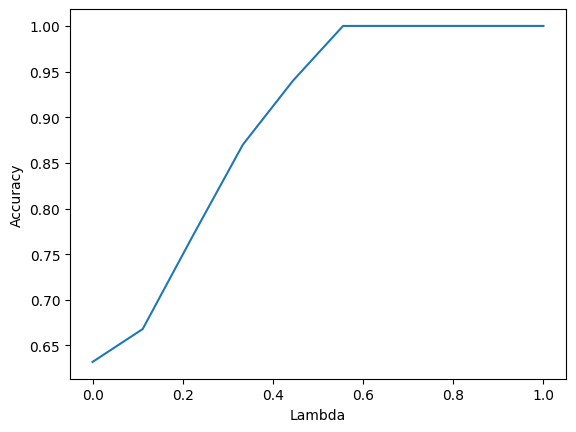

In [11]:
case_1_matrix, lambdas = case_1(pre_opt_pars, opt_pars, test_data)
plt.plot(lambdas, case_1_matrix)
plt.xlabel('Lambda')
plt.ylabel('Accuracy')
plt.show()

CASE 2

lambda  0.0 , accuracy 0.0
lambda  0.11111111 , accuracy 0.0
lambda  0.22222222 , accuracy 0.0
lambda  0.33333334 , accuracy 0.0
lambda  0.44444445 , accuracy 0.0
lambda  0.5555556 , accuracy 0.0
lambda  0.6666667 , accuracy 0.0
lambda  0.7777778 , accuracy 0.776
lambda  0.8888889 , accuracy 0.524
lambda  1.0 , accuracy 0.524


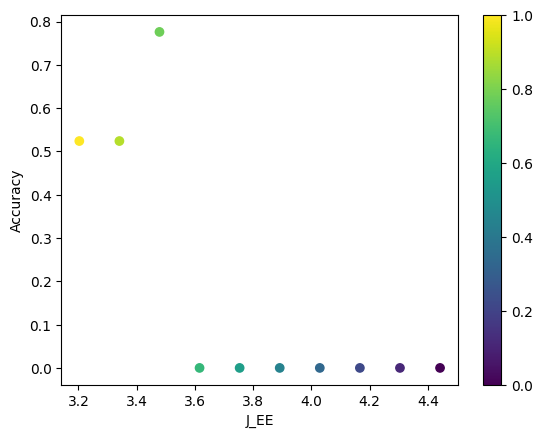

DeviceArray([[ 0.       ,  4.4413204, -2.1914783,  4.076988 , -2.0541077],
             [ 0.       ,  4.3037496, -2.1914783,  4.076988 , -2.0541077],
             [ 0.       ,  4.1661787, -2.1914783,  4.076988 , -2.0541077],
             [ 0.       ,  4.0286074, -2.1914783,  4.076988 , -2.0541077],
             [ 0.       ,  3.891037 , -2.1914783,  4.076988 , -2.0541077],
             [ 0.       ,  3.753466 , -2.1914783,  4.076988 , -2.0541077],
             [ 0.       ,  3.6158948, -2.1914783,  4.076988 , -2.0541077],
             [ 0.776    ,  3.478324 , -2.1914783,  4.076988 , -2.0541077],
             [ 0.524    ,  3.340753 , -2.1914783,  4.076988 , -2.0541077],
             [ 0.524    ,  3.2031822, -2.1914783,  4.076988 , -2.0541077]],            dtype=float32)

In [18]:
case_2(pre_J, post_J, opt_pars, test_data, type_param = 'J', index = (0,0))

## Surround suppression

In [36]:
#def surround_suppresion(ssn_pars, grid_pars, conn_pars, filter_pars, SSN_J_s, SSN_s_s, radius_list, constant_vector, title = None, ref_ori = None):

def surround_suppression(ssn, radius_list, constant_vector, ref_ori):    
    all_responses = []
    #ssn=SSN2DTopoV1_AMPAGABA_ONOFF(ssn_pars, grid_pars, conn_pars, filter_pars, SSN_J_s, SSN_s_s)
    
    if ref_ori==None:
        ref_ori = ssn.ori_map[4,4]
    
    print(ref_ori) #create stimuli in the function just input radii)
    for radii in radius_list:
        
        stimuli_pars['outer_radius'] = radii
        stimuli_pars['inner_radius'] = radii*5/6
        
        test_data = create_data(stimuli_pars, number = 1, offset = 2, ref_ori = ref_ori)
        stimuli = test_data['ref'][0]

        output_ref=np.matmul(ssn.gabor_filters, stimuli) + constant_vector
        SSN_input_ref=np.maximum(0, output_ref)

        #Find the fixed point 
        x_ref, _, _ = obtain_fixed_point(ssn, SSN_input_ref, conv_pars)
        
        centre_response = x_ref[2,2]

        all_responses.append(x_ref.ravel())
        print('Mean population response {} (max in population {}), centre neuron {}'.format(x_ref.mean(), x_ref.max(), centre_response))
    
    
    
    if title:
        plt.plot(radius_list, np.asarray(all_responses))
        plt.xlabel('Radius')
        plt.ylabel('Response of centre neuron')
        if title:
            plt.title(title)
        plt.show()
    
    return np.vstack(all_responses)

In [60]:
def response_matrix(ssn_pars, grid_pars, conn_pars, filter_pars, SSN_J_s, SSN_s_s, radius_list, ori_list, constant_vector):
    '''
    Construct a response matrix of sizze n_orientations x n_neurons x n_radii
    '''
    #Initialize ssn
    ssn=SSN2DTopoV1_AMPAGABA_ONOFF(ssn_pars, grid_pars, conn_pars, filter_pars, SSN_J_s, SSN_s_s)
    
    
    responses = []
    for i in range(len(ori_list)):
        
        #Find responses at different stimuli radii
        x_response = surround_suppression(ssn, radius_list, constant_vector, ref_ori = ori_list[i])
        print(x_response.shape)
        responses.append(x_response)
    
    
    return np.stack(responses, axis = 2)

In [78]:
np.linspace(0, 360, 13)

DeviceArray([  0.,  30.,  60.,  90., 120., 150., 180., 210., 240., 270.,
             300., 330., 360.], dtype=float32)

0.0
Mean population response 0.9240361452102661 (max in population 1.1005029678344727), centre neuron 0.8748261332511902
Mean population response 1.4070483446121216 (max in population 5.172679424285889), centre neuron 5.172679424285889
Mean population response 1.8754602670669556 (max in population 5.916098594665527), centre neuron 5.916098594665527
Mean population response 2.1394126415252686 (max in population 6.235434532165527), centre neuron 6.207638740539551
Mean population response 1.750150203704834 (max in population 6.437403678894043), centre neuron 5.4547929763793945
Mean population response 1.501802921295166 (max in population 6.5237908363342285), centre neuron 6.109688758850098
Mean population response 1.5854558944702148 (max in population 6.607974052429199), centre neuron 5.7165141105651855
Mean population response 1.6344982385635376 (max in population 6.587986946105957), centre neuron 5.865270614624023
Mean population response 1.6792176961898804 (max in population 6.55303907

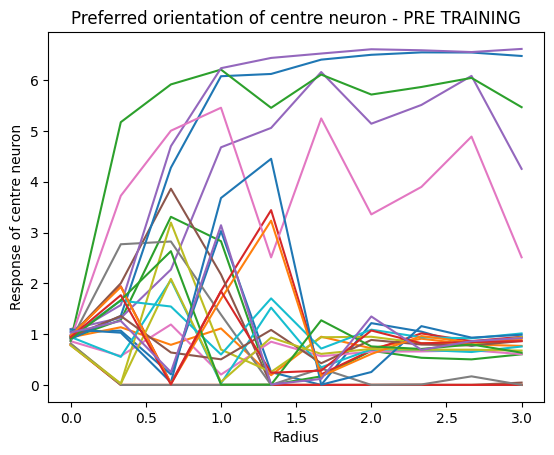

(10, 25)
30.0
Mean population response 0.9240361452102661 (max in population 1.1005029678344727), centre neuron 0.8748261332511902
Mean population response 1.31129789352417 (max in population 4.370114326477051), centre neuron 4.370114326477051
Mean population response 1.3029321432113647 (max in population 3.7471203804016113), centre neuron 2.241774559020996
Mean population response 1.1799530982971191 (max in population 5.559911251068115), centre neuron 0.17247825860977173
Mean population response 1.0421067476272583 (max in population 5.4531779289245605), centre neuron 1.0073570013046265
Mean population response 1.0869933366775513 (max in population 5.518377780914307), centre neuron 0.965483546257019
Mean population response 1.0794373750686646 (max in population 5.6875901222229), centre neuron 0.8012263774871826
Mean population response 1.078844666481018 (max in population 5.41679573059082), centre neuron 0.8669826984405518
Mean population response 1.1038672924041748 (max in population 

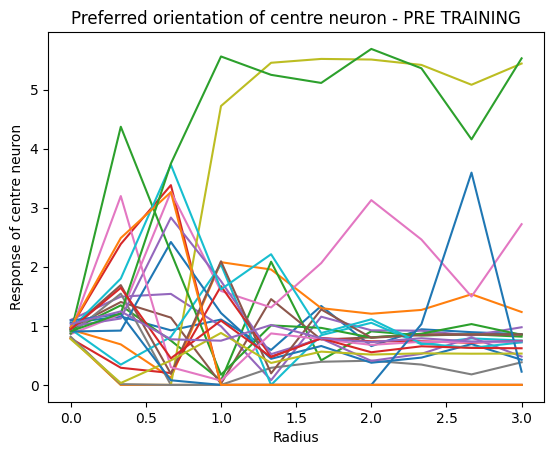

(10, 25)
60.0
Mean population response 0.9240361452102661 (max in population 1.1005029678344727), centre neuron 0.8748261332511902
Mean population response 1.2689164876937866 (max in population 3.7638959884643555), centre neuron 3.7638959884643555
Mean population response 1.3803579807281494 (max in population 6.04256534576416), centre neuron 0.0
Mean population response 1.9911657571792603 (max in population 6.436092376708984), centre neuron 1.7148332595825195
Mean population response 1.8711260557174683 (max in population 6.456362724304199), centre neuron 0.5171915292739868
Mean population response 2.030029535293579 (max in population 6.463232040405273), centre neuron 0.7081091403961182
Mean population response 2.1168463230133057 (max in population 6.489563941955566), centre neuron 0.7144190669059753
Mean population response 2.059354543685913 (max in population 6.520413398742676), centre neuron 0.7291871309280396
Mean population response 1.9517823457717896 (max in population 6.226572513

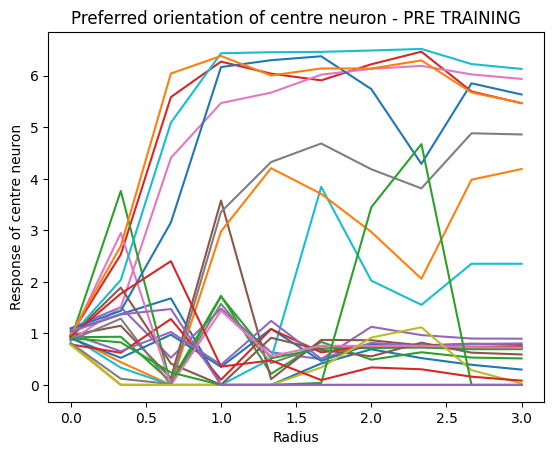

(10, 25)
90.0
Mean population response 0.9240361452102661 (max in population 1.1005029678344727), centre neuron 0.8748261332511902
Mean population response 1.3079861402511597 (max in population 4.099759101867676), centre neuron 4.099759101867676
Mean population response 1.9876153469085693 (max in population 4.835029602050781), centre neuron 0.47921043634414673
Mean population response 1.877784252166748 (max in population 5.935544490814209), centre neuron 0.15581613779067993
Mean population response 1.6597728729248047 (max in population 5.347385883331299), centre neuron 0.8802056312561035
Mean population response 1.048630952835083 (max in population 5.932851314544678), centre neuron 0.7681781053543091
Mean population response 0.9643280506134033 (max in population 6.097965717315674), centre neuron 0.8164655566215515
Mean population response 0.8934632539749146 (max in population 6.32701301574707), centre neuron 0.7907045483589172
Mean population response 1.254293441772461 (max in populati

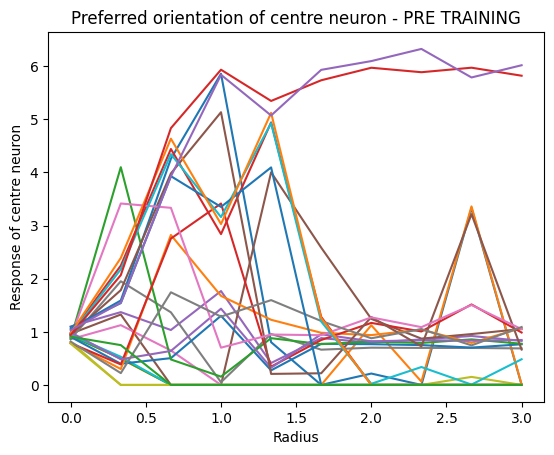

(10, 25)
120.0
Mean population response 0.9240361452102661 (max in population 1.1005029678344727), centre neuron 0.8748261332511902
Mean population response 1.4157145023345947 (max in population 5.144740581512451), centre neuron 5.144740581512451
Mean population response 2.055753707885742 (max in population 5.892531871795654), centre neuron 5.575390338897705
Mean population response 2.0302083492279053 (max in population 6.395847320556641), centre neuron 5.748366832733154
Mean population response 2.3804314136505127 (max in population 6.717886447906494), centre neuron 3.9485843181610107
Mean population response 1.8177587985992432 (max in population 6.60142183303833), centre neuron 5.3779425621032715
Mean population response 1.69772207736969 (max in population 6.654780387878418), centre neuron 5.711395263671875
Mean population response 1.7414695024490356 (max in population 6.684376239776611), centre neuron 5.529605865478516
Mean population response 1.7616698741912842 (max in population 6.

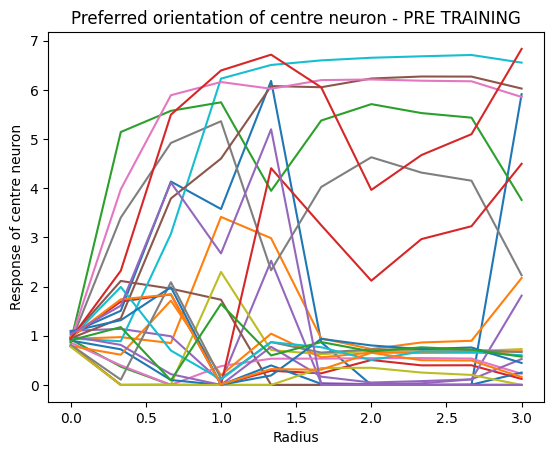

(10, 25)
150.0
Mean population response 0.9240361452102661 (max in population 1.1005029678344727), centre neuron 0.8748261332511902
Mean population response 1.457106590270996 (max in population 5.46176290512085), centre neuron 5.46176290512085
Mean population response 1.9177497625350952 (max in population 6.356086254119873), centre neuron 5.937283515930176
Mean population response 2.150634527206421 (max in population 6.438959121704102), centre neuron 5.40276575088501
Mean population response 1.8091928958892822 (max in population 6.459228992462158), centre neuron 5.140530109405518
Mean population response 1.7556065320968628 (max in population 6.507193088531494), centre neuron 5.244370937347412
Mean population response 1.6798646450042725 (max in population 6.563362121582031), centre neuron 5.235330104827881
Mean population response 1.7139010429382324 (max in population 6.526059150695801), centre neuron 5.11039400100708
Mean population response 1.811651587486267 (max in population 6.40628

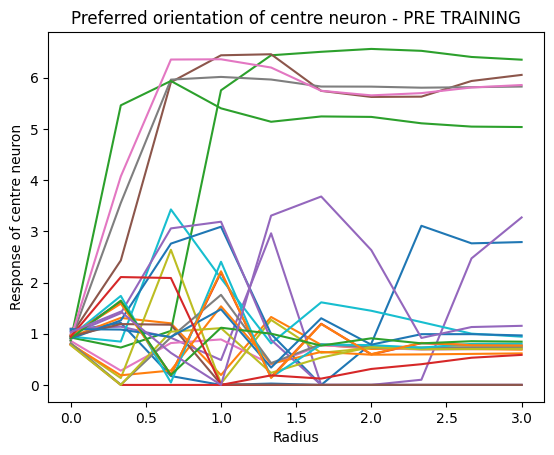

(10, 25)
180.0
Mean population response 0.9240361452102661 (max in population 1.1005029678344727), centre neuron 0.8748261332511902
Mean population response 1.4124531745910645 (max in population 5.202810287475586), centre neuron 5.202810287475586
Mean population response 1.862905502319336 (max in population 5.917872428894043), centre neuron 5.917872428894043
Mean population response 1.9382315874099731 (max in population 6.249469757080078), centre neuron 6.119667053222656
Mean population response 1.7448831796646118 (max in population 6.4338297843933105), centre neuron 5.4326887130737305
Mean population response 1.4571850299835205 (max in population 6.593724250793457), centre neuron 5.943031311035156
Mean population response 1.664103627204895 (max in population 6.586575031280518), centre neuron 5.9185991287231445
Mean population response 1.6186387538909912 (max in population 6.595185279846191), centre neuron 5.8205647468566895
Mean population response 1.5622223615646362 (max in populatio

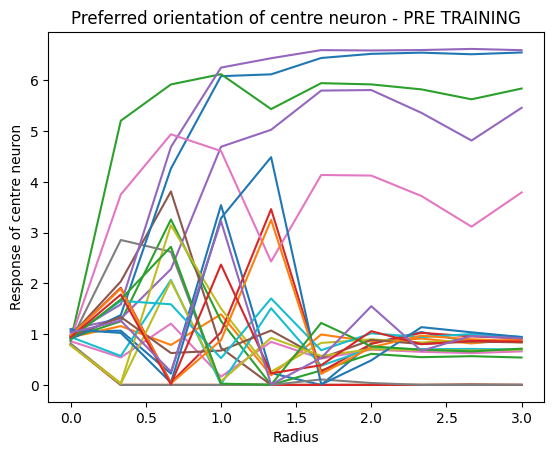

(10, 25)
210.0
Mean population response 0.9240361452102661 (max in population 1.1005029678344727), centre neuron 0.8748261332511902
Mean population response 1.326969861984253 (max in population 4.533496856689453), centre neuron 4.533496856689453
Mean population response 1.2725307941436768 (max in population 3.827833652496338), centre neuron 1.6133743524551392
Mean population response 1.1461573839187622 (max in population 6.074117183685303), centre neuron 0.13265886902809143
Mean population response 1.1245969533920288 (max in population 5.777667045593262), centre neuron 0.9402518272399902
Mean population response 1.1092063188552856 (max in population 5.853549957275391), centre neuron 0.8009628653526306
Mean population response 1.108931064605713 (max in population 5.203409671783447), centre neuron 1.0127887725830078
Mean population response 1.0784481763839722 (max in population 5.417693614959717), centre neuron 0.8632209897041321
Mean population response 1.080080509185791 (max in populat

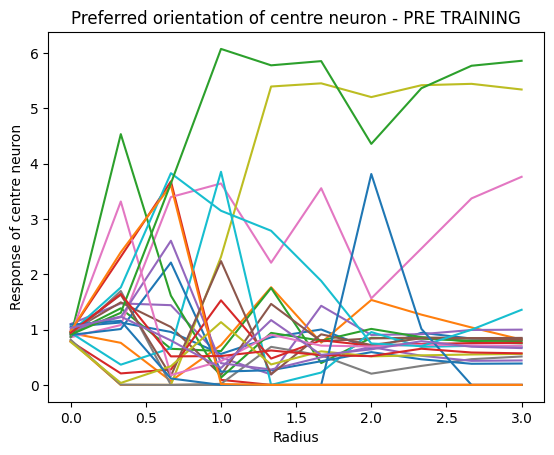

(10, 25)
240.0
Mean population response 0.9240361452102661 (max in population 1.1005029678344727), centre neuron 0.8748261332511902
Mean population response 1.2691388130187988 (max in population 3.769594192504883), centre neuron 3.769594192504883
Mean population response 1.4402961730957031 (max in population 6.050531387329102), centre neuron 0.0
Mean population response 1.9552059173583984 (max in population 6.4599738121032715), centre neuron 1.728991150856018
Mean population response 1.8319977521896362 (max in population 6.4152445793151855), centre neuron 0.511303186416626
Mean population response 1.9472652673721313 (max in population 6.257955551147461), centre neuron 0.6884986758232117
Mean population response 1.9947478771209717 (max in population 6.273410320281982), centre neuron 0.6970261931419373
Mean population response 2.0724422931671143 (max in population 6.393285751342773), centre neuron 0.7057948708534241
Mean population response 1.903581142425537 (max in population 6.13313436

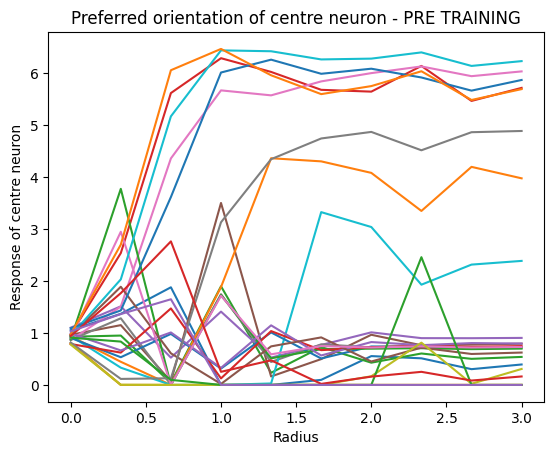

(10, 25)
270.0
Mean population response 0.9240361452102661 (max in population 1.1005029678344727), centre neuron 0.8748261332511902
Mean population response 1.312825322151184 (max in population 4.152740001678467), centre neuron 4.152740001678467
Mean population response 2.020923614501953 (max in population 5.039082050323486), centre neuron 1.1943027973175049
Mean population response 1.9031238555908203 (max in population 5.897483825683594), centre neuron 0.1634211242198944
Mean population response 1.3992561101913452 (max in population 6.546604156494141), centre neuron 0.9606955051422119
Mean population response 1.3342596292495728 (max in population 6.028520107269287), centre neuron 0.8621876835823059
Mean population response 1.0650852918624878 (max in population 5.2598137855529785), centre neuron 0.7491975426673889
Mean population response 1.0111476182937622 (max in population 5.167949199676514), centre neuron 0.743044376373291
Mean population response 1.2922866344451904 (max in populat

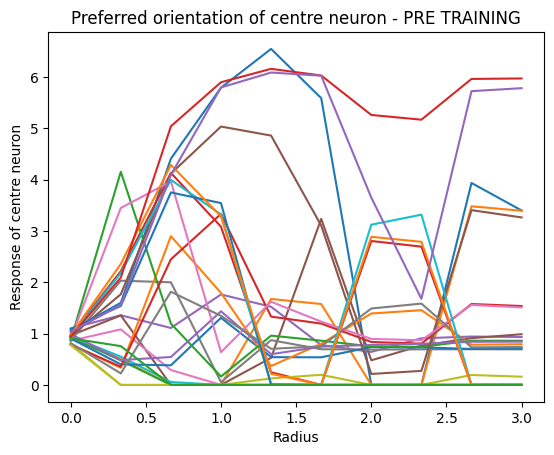

(10, 25)
300.0
Mean population response 0.9240361452102661 (max in population 1.1005029678344727), centre neuron 0.8748261332511902
Mean population response 1.4082881212234497 (max in population 5.0745768547058105), centre neuron 5.0745768547058105
Mean population response 2.0480611324310303 (max in population 6.1314215660095215), centre neuron 5.87578010559082
Mean population response 2.0303094387054443 (max in population 6.3960466384887695), centre neuron 5.7481794357299805
Mean population response 1.876661777496338 (max in population 6.506219387054443), centre neuron 5.849188327789307
Mean population response 1.688284993171692 (max in population 6.635091304779053), centre neuron 5.786831855773926
Mean population response 2.085160970687866 (max in population 6.942467212677002), centre neuron 3.856555223464966
Mean population response 1.7428399324417114 (max in population 6.685823440551758), centre neuron 5.5246171951293945
Mean population response 2.0403096675872803 (max in populatio

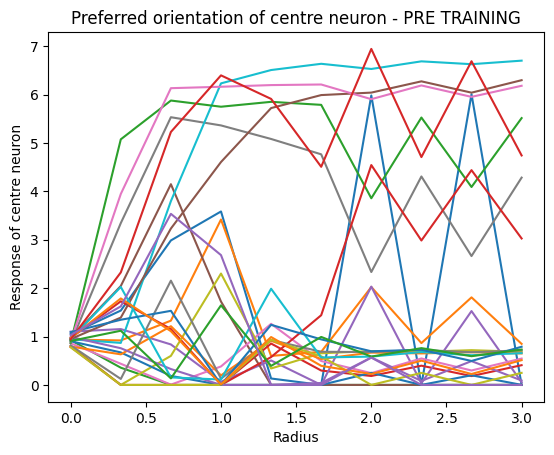

(10, 25)
330.0
Mean population response 0.9240361452102661 (max in population 1.1005029678344727), centre neuron 0.8748261332511902
Mean population response 1.4555336236953735 (max in population 5.453213691711426), centre neuron 5.453213691711426
Mean population response 1.9316712617874146 (max in population 6.319859027862549), centre neuron 5.914677143096924
Mean population response 2.1272943019866943 (max in population 6.469476699829102), centre neuron 5.413276672363281
Mean population response 1.9579027891159058 (max in population 6.473948001861572), centre neuron 5.127352237701416
Mean population response 1.7692174911499023 (max in population 6.526900291442871), centre neuron 5.2036662101745605
Mean population response 1.7581819295883179 (max in population 6.570008754730225), centre neuron 5.130187511444092
Mean population response 1.626708984375 (max in population 6.549643516540527), centre neuron 5.2822957038879395
Mean population response 1.6688510179519653 (max in population 6.

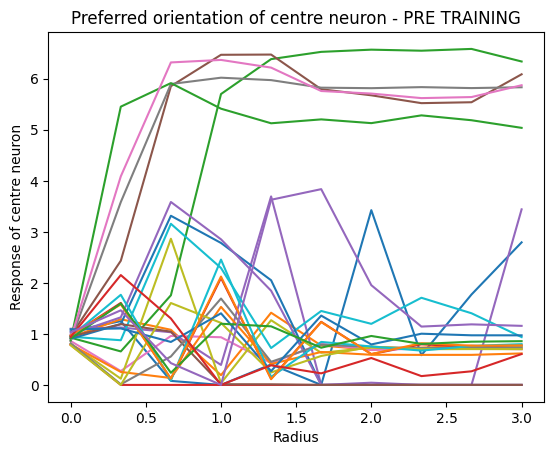

(10, 25)
360.0
Mean population response 0.9240361452102661 (max in population 1.1005029678344727), centre neuron 0.8748261332511902
Mean population response 1.407957911491394 (max in population 5.178308486938477), centre neuron 5.178308486938477
Mean population response 1.8860889673233032 (max in population 5.918876647949219), centre neuron 5.918876647949219
Mean population response 1.7483596801757812 (max in population 6.160061836242676), centre neuron 5.621567726135254
Mean population response 1.805721402168274 (max in population 6.480947494506836), centre neuron 5.68231201171875
Mean population response 1.4303089380264282 (max in population 6.6146559715271), centre neuron 5.774080753326416
Mean population response 1.62581467628479 (max in population 6.598732948303223), centre neuron 5.827491760253906
Mean population response 1.5879583358764648 (max in population 6.606100559234619), centre neuron 5.734694004058838
Mean population response 1.6410307884216309 (max in population 6.57381

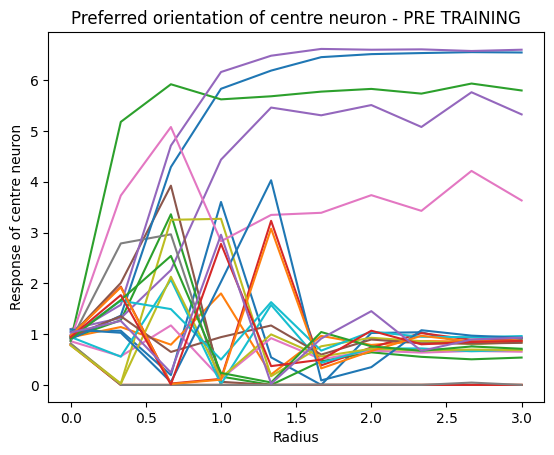

(10, 25)


In [79]:
radius_list = np.linspace(0,3,10)
ori_list = np.linspace(0, 360, 13)

pre_responses = response_matrix(ssn_pars, grid_pars, conn_pars, filter_pars, pre_J, pre_s, radius_list, ori_list, constant_vector)

0.0
Mean population response 0.654945969581604 (max in population 0.7580481171607971), centre neuron 0.6335280537605286
Mean population response 1.1976789236068726 (max in population 6.829380989074707), centre neuron 6.829380989074707
Mean population response 1.8259201049804688 (max in population 10.658903121948242), centre neuron 10.658903121948242
Mean population response 2.153383493423462 (max in population 11.414069175720215), centre neuron 11.414069175720215
Mean population response 2.053661346435547 (max in population 10.552536010742188), centre neuron 8.559104919433594
Mean population response 2.018763542175293 (max in population 12.62241268157959), centre neuron 10.922589302062988
Mean population response 1.9351662397384644 (max in population 12.313632011413574), centre neuron 8.899455070495605
Mean population response 1.9034864902496338 (max in population 12.458747863769531), centre neuron 8.811606407165527
Mean population response 1.545907974243164 (max in population 10.88677

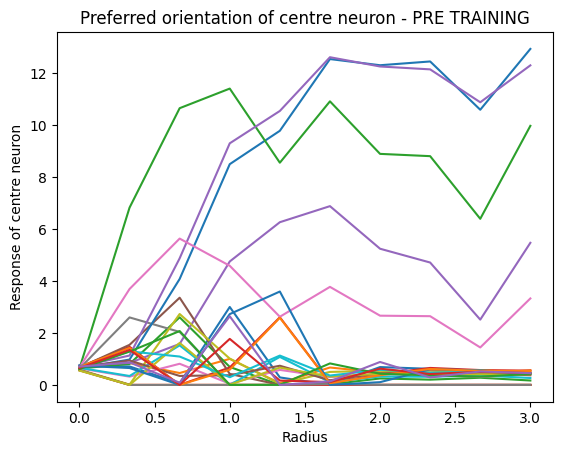

(10, 25)
30.0
Mean population response 0.654945969581604 (max in population 0.7580481171607971), centre neuron 0.6335280537605286
Mean population response 1.0715923309326172 (max in population 5.207077503204346), centre neuron 5.207077503204346
Mean population response 1.0116052627563477 (max in population 3.8100318908691406), centre neuron 0.6718485355377197
Mean population response 0.9801617860794067 (max in population 7.623656749725342), centre neuron 0.042925573885440826
Mean population response 0.960872232913971 (max in population 7.519717216491699), centre neuron 0.561385452747345
Mean population response 0.8254285454750061 (max in population 6.100635528564453), centre neuron 0.7339219450950623
Mean population response 0.7593714594841003 (max in population 5.921465873718262), centre neuron 0.6199811100959778
Mean population response 0.7399082183837891 (max in population 5.208098888397217), centre neuron 0.7303956151008606
Mean population response 0.7954304218292236 (max in popula

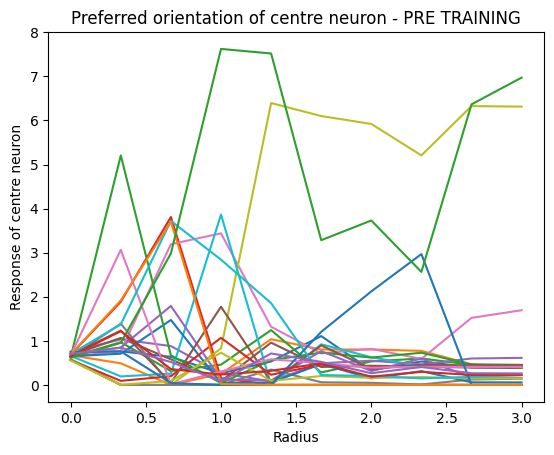

(10, 25)
60.0
Mean population response 0.654945969581604 (max in population 0.7580481171607971), centre neuron 0.6335280537605286
Mean population response 0.9946833848953247 (max in population 3.6372265815734863), centre neuron 3.6372265815734863
Mean population response 1.459620475769043 (max in population 8.217686653137207), centre neuron 0.0
Mean population response 2.323765277862549 (max in population 13.573575973510742), centre neuron 1.149248480796814
Mean population response 2.9170918464660645 (max in population 16.572765350341797), centre neuron 0.2826181948184967
Mean population response 3.0989043712615967 (max in population 17.179058074951172), centre neuron 0.378131628036499
Mean population response 3.320821523666382 (max in population 17.687820434570312), centre neuron 0.369873046875
Mean population response 3.398812770843506 (max in population 18.20733070373535), centre neuron 0.3497629463672638
Mean population response 3.1718482971191406 (max in population 17.359611511230

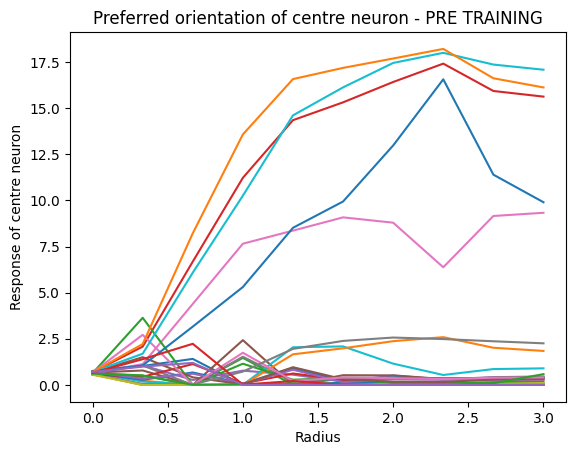

(10, 25)
90.0
Mean population response 0.654945969581604 (max in population 0.7580481171607971), centre neuron 0.6335280537605286
Mean population response 1.046408772468567 (max in population 4.338719844818115), centre neuron 4.338719844818115
Mean population response 1.7943694591522217 (max in population 5.615864276885986), centre neuron 0.030441701412200928
Mean population response 1.902571678161621 (max in population 8.080184936523438), centre neuron 0.033754415810108185
Mean population response 1.4710677862167358 (max in population 10.509926795959473), centre neuron 0.46275848150253296
Mean population response 0.9338586330413818 (max in population 5.721561431884766), centre neuron 0.32685187458992004
Mean population response 1.456939697265625 (max in population 14.057876586914062), centre neuron 0.3550398051738739
Mean population response 0.6735406517982483 (max in population 7.103863716125488), centre neuron 0.3422624468803406
Mean population response 1.318727731704712 (max in pop

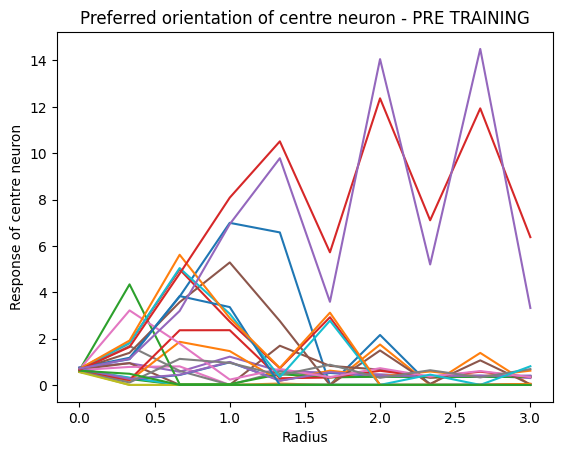

(10, 25)
120.0
Mean population response 0.654945969581604 (max in population 0.7580481171607971), centre neuron 0.6335280537605286
Mean population response 1.194351077079773 (max in population 6.416078090667725), centre neuron 6.416078090667725
Mean population response 2.2091526985168457 (max in population 10.428658485412598), centre neuron 10.428658485412598
Mean population response 2.5608766078948975 (max in population 10.790521621704102), centre neuron 4.376433372497559
Mean population response 3.0010647773742676 (max in population 13.589811325073242), centre neuron 3.328390121459961
Mean population response 2.149179697036743 (max in population 13.900253295898438), centre neuron 6.935921669006348
Mean population response 2.4017887115478516 (max in population 14.265970230102539), centre neuron 4.370609283447266
Mean population response 2.635517120361328 (max in population 15.314603805541992), centre neuron 3.4257166385650635
Mean population response 2.208836078643799 (max in populati

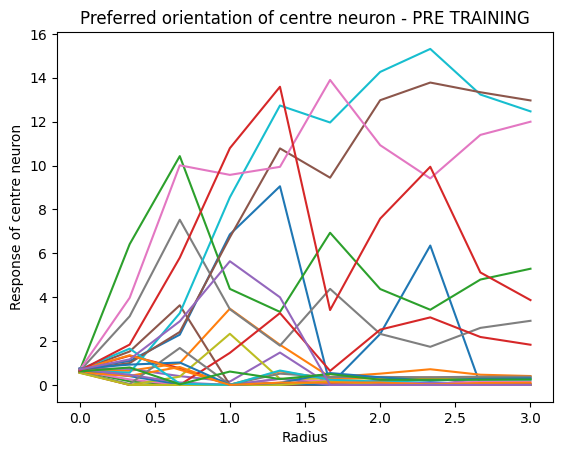

(10, 25)
150.0
Mean population response 0.654945969581604 (max in population 0.7580481171607971), centre neuron 0.6335280537605286
Mean population response 1.2567334175109863 (max in population 7.352494716644287), centre neuron 7.352494716644287
Mean population response 2.2935948371887207 (max in population 14.713400840759277), centre neuron 14.713400840759277
Mean population response 2.9285974502563477 (max in population 16.525659561157227), centre neuron 16.525659561157227
Mean population response 2.9870030879974365 (max in population 17.02251434326172), centre neuron 16.344345092773438
Mean population response 3.376551389694214 (max in population 18.02290916442871), centre neuron 16.60350799560547
Mean population response 3.292870044708252 (max in population 18.069772720336914), centre neuron 16.543075561523438
Mean population response 3.244136333465576 (max in population 18.73487663269043), centre neuron 16.12497901916504
Mean population response 3.1372673511505127 (max in populati

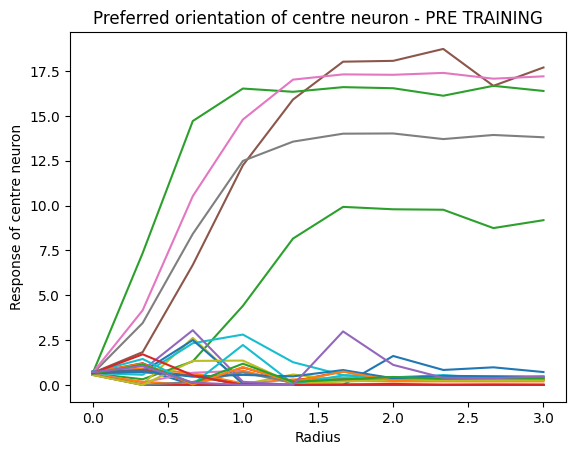

(10, 25)
180.0
Mean population response 0.654945969581604 (max in population 0.7580481171607971), centre neuron 0.6335280537605286
Mean population response 1.2000800371170044 (max in population 6.854951858520508), centre neuron 6.854951858520508
Mean population response 1.7966899871826172 (max in population 10.455144882202148), centre neuron 10.455144882202148
Mean population response 1.8956698179244995 (max in population 8.999716758728027), centre neuron 8.999716758728027
Mean population response 2.2986488342285156 (max in population 11.455703735351562), centre neuron 11.455703735351562
Mean population response 2.1363933086395264 (max in population 12.649491310119629), centre neuron 12.128294944763184
Mean population response 1.7766013145446777 (max in population 11.803900718688965), centre neuron 7.7243146896362305
Mean population response 1.9884408712387085 (max in population 12.799993515014648), centre neuron 9.510932922363281
Mean population response 1.7896876335144043 (max in pop

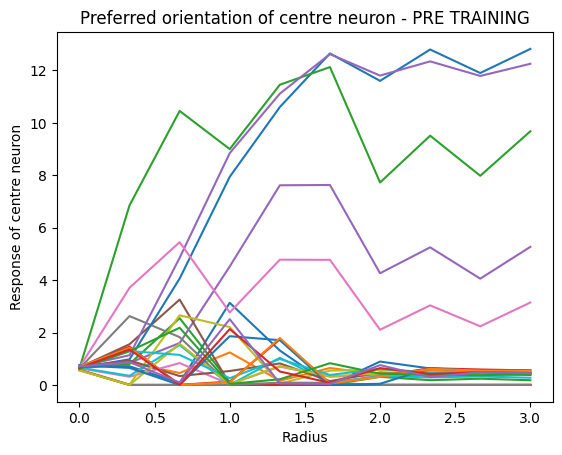

(10, 25)
210.0
Mean population response 0.654945969581604 (max in population 0.7580481171607971), centre neuron 0.6335280537605286
Mean population response 1.0501899719238281 (max in population 4.857266426086426), centre neuron 4.857266426086426
Mean population response 1.0505976676940918 (max in population 3.413609027862549), centre neuron 2.639295816421509
Mean population response 0.9790945053100586 (max in population 7.625686168670654), centre neuron 0.04425506666302681
Mean population response 0.9894105792045593 (max in population 7.998876094818115), centre neuron 0.5526683330535889
Mean population response 0.9434626698493958 (max in population 8.670550346374512), centre neuron 0.4408639073371887
Mean population response 0.8654804229736328 (max in population 7.2006144523620605), centre neuron 0.45769116282463074
Mean population response 0.751272976398468 (max in population 5.520174026489258), centre neuron 0.6687244772911072
Mean population response 0.8326283097267151 (max in popul

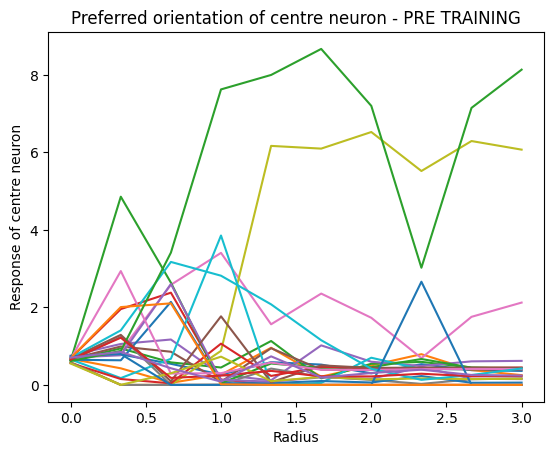

(10, 25)
240.0
Mean population response 0.654945969581604 (max in population 0.7580481171607971), centre neuron 0.6335280537605286
Mean population response 0.9940779805183411 (max in population 3.6426093578338623), centre neuron 3.6426093578338623
Mean population response 1.36431884765625 (max in population 8.06431770324707), centre neuron 0.0
Mean population response 2.476998805999756 (max in population 13.674726486206055), centre neuron 1.2330362796783447
Mean population response 3.0270984172821045 (max in population 16.873550415039062), centre neuron 0.2537803649902344
Mean population response 3.1314587593078613 (max in population 17.304000854492188), centre neuron 0.37611567974090576
Mean population response 3.4292306900024414 (max in population 18.198060989379883), centre neuron 0.35994940996170044
Mean population response 3.0240087509155273 (max in population 16.87043571472168), centre neuron 0.3882006108760834
Mean population response 3.318070650100708 (max in population 17.7724

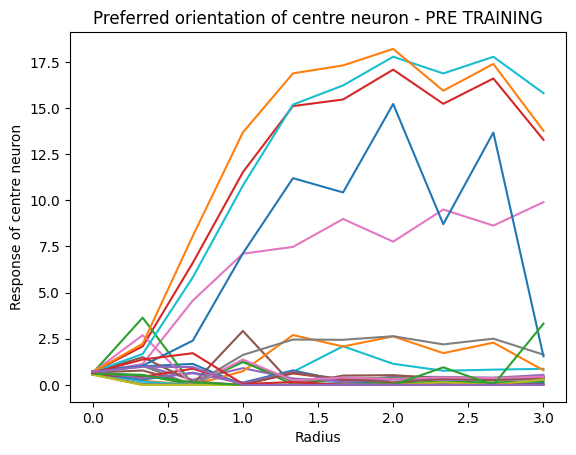

(10, 25)
270.0
Mean population response 0.654945969581604 (max in population 0.7580481171607971), centre neuron 0.6335280537605286
Mean population response 1.0692753791809082 (max in population 4.6799139976501465), centre neuron 4.6799139976501465
Mean population response 1.8615063428878784 (max in population 5.641806125640869), centre neuron 0.7406629323959351
Mean population response 1.9070838689804077 (max in population 7.719093322753906), centre neuron 0.044745467603206635
Mean population response 1.3855868577957153 (max in population 8.878132820129395), centre neuron 0.4618707597255707
Mean population response 0.9146025776863098 (max in population 7.557234287261963), centre neuron 0.3369213044643402
Mean population response 1.6854374408721924 (max in population 15.003331184387207), centre neuron 0.3579710125923157
Mean population response 0.9516923427581787 (max in population 10.171235084533691), centre neuron 0.34505748748779297
Mean population response 0.7655640244483948 (max in

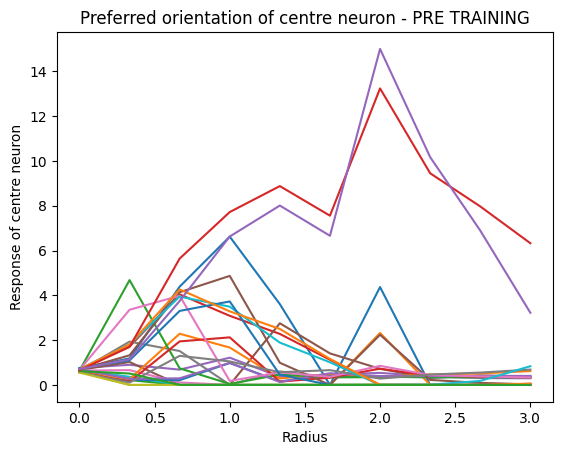

(10, 25)
300.0
Mean population response 0.654945969581604 (max in population 0.7580481171607971), centre neuron 0.6335280537605286
Mean population response 1.2061576843261719 (max in population 6.585825443267822), centre neuron 6.585825443267822
Mean population response 2.166569232940674 (max in population 9.511045455932617), centre neuron 9.279794692993164
Mean population response 2.4625818729400635 (max in population 11.697330474853516), centre neuron 7.4134087562561035
Mean population response 3.144132614135742 (max in population 14.465437889099121), centre neuron 2.679001569747925
Mean population response 2.1898367404937744 (max in population 13.30090618133545), centre neuron 6.331546783447266
Mean population response 2.0871853828430176 (max in population 13.968441009521484), centre neuron 6.953994274139404
Mean population response 2.6864101886749268 (max in population 15.498821258544922), centre neuron 3.2945713996887207
Mean population response 2.9979970455169678 (max in populati

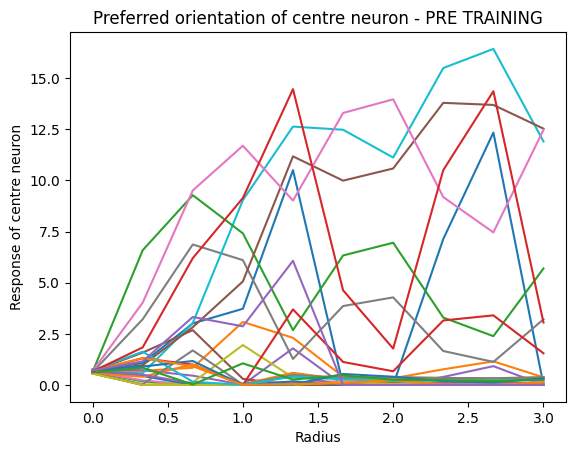

(10, 25)
330.0
Mean population response 0.654945969581604 (max in population 0.7580481171607971), centre neuron 0.6335280537605286
Mean population response 1.2583527565002441 (max in population 7.432780742645264), centre neuron 7.432780742645264
Mean population response 2.28279185295105 (max in population 14.59231948852539), centre neuron 14.59231948852539
Mean population response 2.9647085666656494 (max in population 16.7607479095459), centre neuron 16.7607479095459
Mean population response 3.0375442504882812 (max in population 16.95655632019043), centre neuron 16.95655632019043
Mean population response 3.3840861320495605 (max in population 17.85694694519043), centre neuron 16.767696380615234
Mean population response 3.2917585372924805 (max in population 19.435503005981445), centre neuron 15.900364875793457
Mean population response 3.18192982673645 (max in population 17.14783477783203), centre neuron 16.645187377929688
Mean population response 2.997861623764038 (max in population 17.5

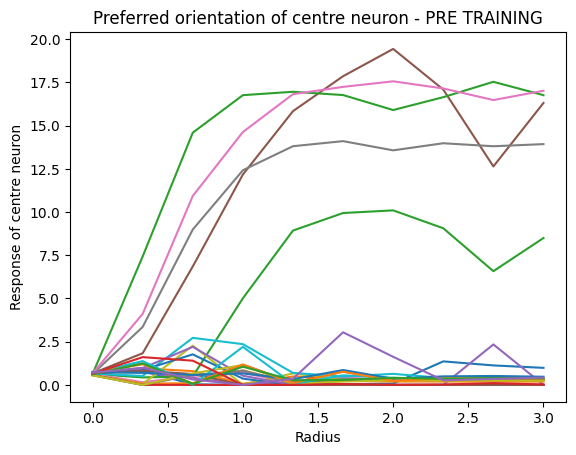

(10, 25)
360.0
Mean population response 0.654945969581604 (max in population 0.7580481171607971), centre neuron 0.6335280537605286
Mean population response 1.1727060079574585 (max in population 6.558497428894043), centre neuron 6.558497428894043
Mean population response 1.8606891632080078 (max in population 10.91733455657959), centre neuron 10.91733455657959
Mean population response 1.8184870481491089 (max in population 8.631250381469727), centre neuron 8.238985061645508
Mean population response 2.1949546337127686 (max in population 10.96784782409668), centre neuron 10.217238426208496
Mean population response 1.8795782327651978 (max in population 12.438840866088867), centre neuron 9.583782196044922
Mean population response 1.6714301109313965 (max in population 11.436705589294434), centre neuron 7.023215293884277
Mean population response 1.5550018548965454 (max in population 11.006625175476074), centre neuron 6.50058650970459
Mean population response 1.748681902885437 (max in population

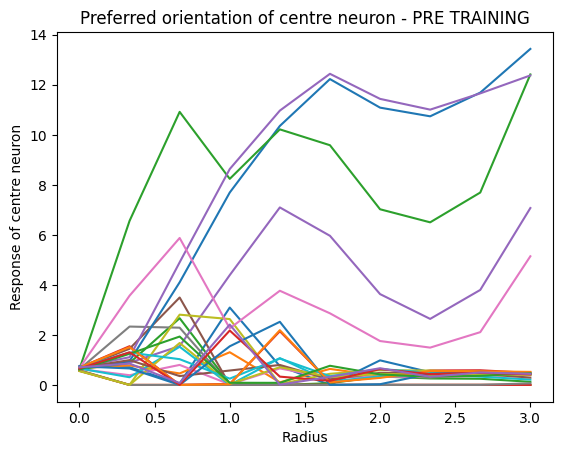

(10, 25)


In [80]:
post_responses = response_matrix(ssn_pars, grid_pars, conn_pars, filter_pars, post_J, post_s, radius_list, ori_list, constant_vector)

In [108]:
post_responses.max()

DeviceArray(19.435503, dtype=float32)

In [ ]:
radius_list = np.linspace(0, 3.2, 10)
constant_vector = constant_to_vec(opt_pars['c_E'], opt_pars['c_I'])
surround_suppresion(ssn_pars, grid_pars, conn_pars, filter_pars, pre_J, pre_s, radius_list, constant_vector)

In [91]:
def plot_quadrants(ssn_pars, grid_pars, conn_pars, filter_pars, J_2x2, s_2x2, constant_vector, ref_ori = None, radii = 3):
    
    ssn=SSN2DTopoV1_AMPAGABA_ONOFF(ssn_pars=ssn_pars, grid_pars=grid_pars, conn_pars=conn_pars, filter_pars=filter_pars, J_2x2=J_2x2, s_2x2=s_2x2)
    print(ssn.ori_map[2:7, 2:7])
    stimuli_pars['outer_radius'] = radii
    stimuli_pars['inner_radius'] = radii*5/6
    
    if ref_ori==None:
        ref_ori = ssn.ori_map[4,4]
    print(ref_ori)

    test_data = create_data(stimuli_pars, number = 1, offset = 2, ref_ori = ref_ori)
    stimuli = test_data['ref'][0]

    output_ref=np.matmul(ssn.gabor_filters, stimuli) + constant_vector
    SSN_input_ref=np.maximum(0, output_ref)

    #Find the fixed point 
    x_ref, _, _ = obtain_fixed_point(ssn, SSN_input_ref, conv_pars)
    print(x_ref.shape)

    return x_ref



In [34]:
filter_pars

__main__.filter_pars

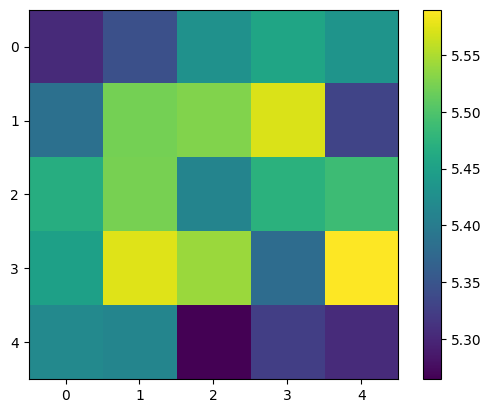

In [39]:
Js0_set2 = [1.72881688, 1.29887564, 1.48514091, 0.76417991]
gE, gI = 0.5821754, 0.22660373

sigEE, sigIE = 0.225, 0.242
sigEI, sigII = .09, .09

class conn_pars_set2():
    PERIODIC = False
    p_local = [0, 0] # [p_local_EE, p_local_IE],
    sigma_oris = 1000

make_J2x2 = lambda Jee, Jei, Jie, Jii: np.array([[Jee, -Jei], [Jie,  -Jii]]) * np.pi * ssn_pars.psi
J_2x2_set2 = make_J2x2(*Js0_set2)
s_2x2_set2 = np.array([[sigEE, sigEI],[sigIE, sigII]])



ssn=SSN2DTopoV1_AMPAGABA_ONOFF(ssn_pars, grid_pars, conn_pars, filter_pars, J_2x2=pre_J, s_2x2=pre_s, gE = 1, gI=1)

SSN_input_test =numpy.zeros((324,))
SSN_input_test[0:162] = 100*gE
SSN_input_test[162:] = 100*gI

x_ref, _, _ = obtain_fixed_point(ssn, SSN_input_test, conv_pars)

plt.imshow(x_ref)
plt.colorbar()
plt.show()

In [23]:
ssn=SSN2DTopoV1_AMPAGABA_ONOFF(ssn_pars=ssn_pars, grid_pars=grid_pars, conn_pars=conn_pars_set2, filter_pars=filter_pars, J_2x2=J_2x2_set2, s_2x2=s_2x2_set2, gE = gE, gI=gI)
test_data = create_data(stimuli_pars, number = 1, offset = 2, ref_ori = ref_ori)
test_stimuli = test_data['ref'][0]
stimuli_pars

output_ref=np.matmul(ssn.gabor_filters, test_stimuli)
output_ref.max()

DeviceArray(3.8720435e-05, dtype=float32)

In [101]:
pre_centre_set2 = plot_quadrants(ssn_pars, grid_pars, conn_pars_set2, filter_pars, J_2x2_set2, s_2x2_set2, constant_vector, ref_ori = None)
pre_centre = plot_quadrants(ssn_pars, grid_pars, conn_pars, filter_pars, pre_J, pre_s, constant_vector, ref_ori = None)

[[113.25367   71.095535 125.170784  68.936874 147.55812 ]
 [139.69272   65.28     158.2295    59.624653 100.688194]
 [168.48268   37.070847 153.29688  142.58534  170.18488 ]
 [129.67758  142.7895    43.32506   79.09537   54.744198]
 [ 59.648876  68.92113   61.18207   97.5979    97.63669 ]]
153.29688
(5, 5)
[[113.25367   71.095535 125.170784  68.936874 147.55812 ]
 [139.69272   65.28     158.2295    59.624653 100.688194]
 [168.48268   37.070847 153.29688  142.58534  170.18488 ]
 [129.67758  142.7895    43.32506   79.09537   54.744198]
 [ 59.648876  68.92113   61.18207   97.5979    97.63669 ]]
153.29688
(5, 5)


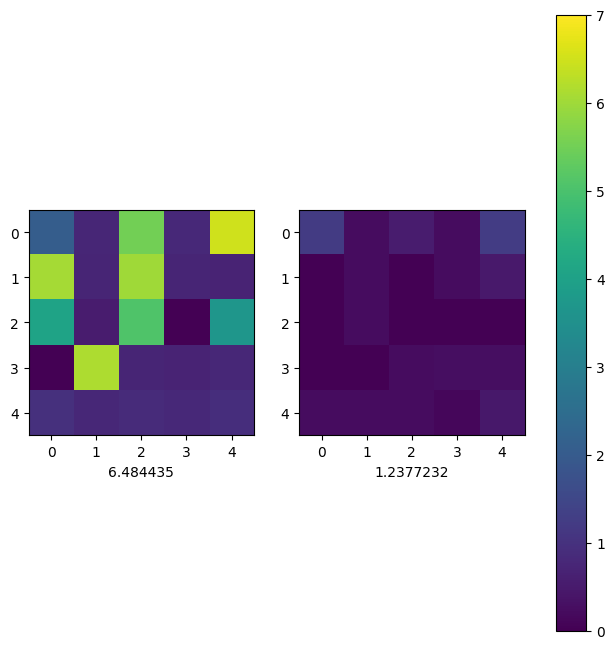

In [106]:
all_responses = [pre_centre, pre_centre_set2]
count = 0

fig, axes = plt.subplots(1,2, figsize=(8,8))
for ax in axes.flat:

    im = ax.imshow(all_responses[count], vmin = 0, vmax = 7)
    ax.set_xlabel(all_responses[count].max())

    count+=1

plt.colorbar(im, ax=axes.ravel().tolist())
plt.show()

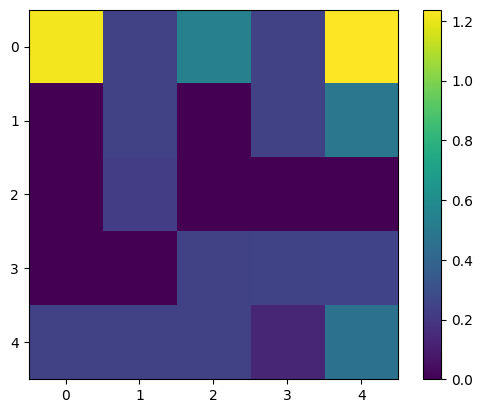

In [102]:
plt.imshow(pre_centre_set2)
plt.colorbar()

In [63]:
pre_centre = plot_quadrants(ssn_pars, grid_pars, conn_pars, filter_pars, pre_J, pre_s, constant_vector, ref_ori = None)
pre_trained = plot_quadrants(ssn_pars, grid_pars, conn_pars, filter_pars, pre_J, pre_s, constant_vector, ref_ori = 55)
post_centre = plot_quadrants(ssn_pars, grid_pars, conn_pars, filter_pars, post_J, post_s, constant_vector, ref_ori = None)
post_trained = plot_quadrants(ssn_pars, grid_pars, conn_pars, filter_pars, post_J, post_s, constant_vector, ref_ori = 55)

[[113.25367   71.095535 125.170784  68.936874 147.55812 ]
 [139.69272   65.28     158.2295    59.624653 100.688194]
 [168.48268   37.070847 153.29688  142.58534  170.18488 ]
 [129.67758  142.7895    43.32506   79.09537   54.744198]
 [ 59.648876  68.92113   61.18207   97.5979    97.63669 ]]
153.29688
(5, 5)
[[113.25367   71.095535 125.170784  68.936874 147.55812 ]
 [139.69272   65.28     158.2295    59.624653 100.688194]
 [168.48268   37.070847 153.29688  142.58534  170.18488 ]
 [129.67758  142.7895    43.32506   79.09537   54.744198]
 [ 59.648876  68.92113   61.18207   97.5979    97.63669 ]]
55
(5, 5)
[[113.25367   71.095535 125.170784  68.936874 147.55812 ]
 [139.69272   65.28     158.2295    59.624653 100.688194]
 [168.48268   37.070847 153.29688  142.58534  170.18488 ]
 [129.67758  142.7895    43.32506   79.09537   54.744198]
 [ 59.648876  68.92113   61.18207   97.5979    97.63669 ]]
153.29688
(5, 5)
[[113.25367   71.095535 125.170784  68.936874 147.55812 ]
 [139.69272   65.28     1

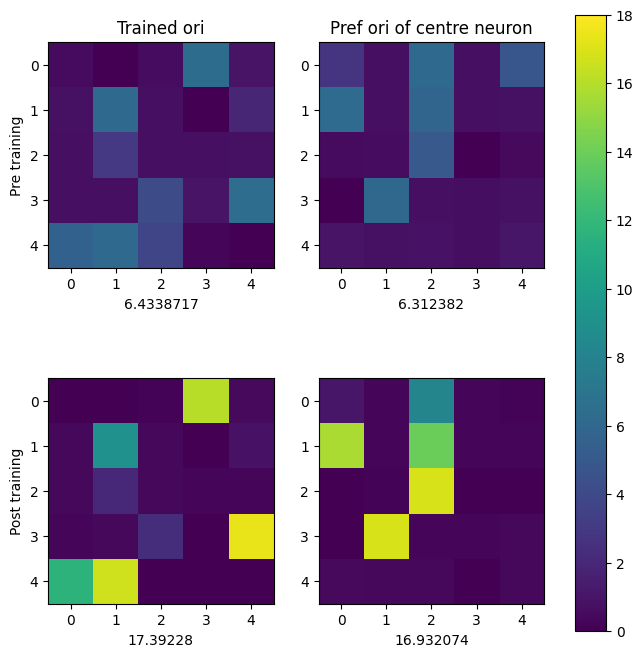

In [70]:
all_responses = [pre_trained, pre_centre, post_trained, post_centre]
count = 0

fig, axes = plt.subplots(2,2, figsize=(8,8))
for ax in axes.flat:

    im = ax.imshow(all_responses[count], vmin = 0, vmax = 18)
    ax.set_xlabel(all_responses[count].max())
    if count ==0:
        ax.title.set_text('Trained ori')
        ax.set_ylabel('Pre training')
    if count ==1:
        ax.title.set_text('Pref ori of centre neuron')
    if count ==2:
        ax.set_ylabel('Post training')
    count+=1

plt.colorbar(im, ax=axes.ravel().tolist())
plt.show()

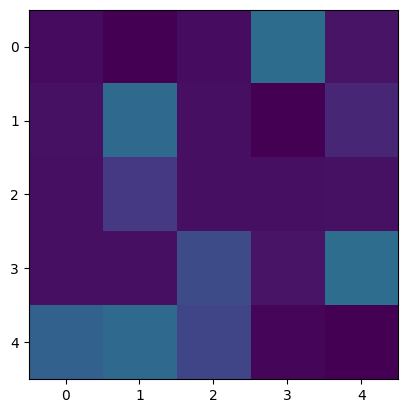

In [77]:
test_ravel = pre_trained.ravel()
plt.imshow(test_ravel.reshape(5,5), vmin = 0, vmax = 18)